In [1]:
#Import required libraries
%matplotlib inline
import numpy as np
import os
from geopandas import GeoSeries, GeoDataFrame, read_file, gpd
import pandas as pd
from matplotlib import pyplot as plt
import IPython

import cartopy.crs as ccrs # for projection

In [2]:
#Load EEZ data from shapefile
input_file = 'eez_v12_0_360.shp'

if os.path.exists(input_file):
    print('Input file:', input_file)
else:
    print('Please download the data or fix the path!')

Input file: eez_v12_0_360.shp


In [3]:
#Read data and take a look at the column headers etc
eez_data = gpd.read_file(input_file)
eez_data.head(1)

,MRGID,GEONAME,MRGID_TER1,POL_TYPE,MRGID_SOV1,TERRITORY1,ISO_TER1,SOVEREIGN1,MRGID_TER2,MRGID_SOV2,...,ISO_SOV1,ISO_SOV2,ISO_SOV3,UN_SOV1,UN_SOV2,UN_SOV3,UN_TER1,UN_TER2,UN_TER3,geometry
0,8444,United States Exclusive Economic Zone (America...,8670.0,200NM,2204,American Samoa,ASM,United States,NaN,NaN,...,USA,None,None,840,NaN,NaN,16.0,NaN,NaN,"POLYGON ((193.36 -17.555, 193.35 -17.552, 193...."


In [4]:
#Reduce dataset to only necessary columns
eez_data = eez_data[['SOVEREIGN1','geometry']]

In [5]:
eez_data.head()

,SOVEREIGN1,geometry
0,United States,"POLYGON ((193.36 -17.555, 193.35 -17.552, 193...."
1,United Kingdom,"POLYGON ((349.07 -7.8893, 349.07 -7.9039, 349...."
2,New Zealand,"POLYGON ((201.62 -6.3777, 201.9 -6.5611, 202.3..."
3,United Kingdom,"POLYGON ((298.38 -53.782, 298.33 -53.759, 298...."
4,France,"MULTIPOLYGON (((224.07 -7.9013, 224.07 -7.903,..."


<Axes: >

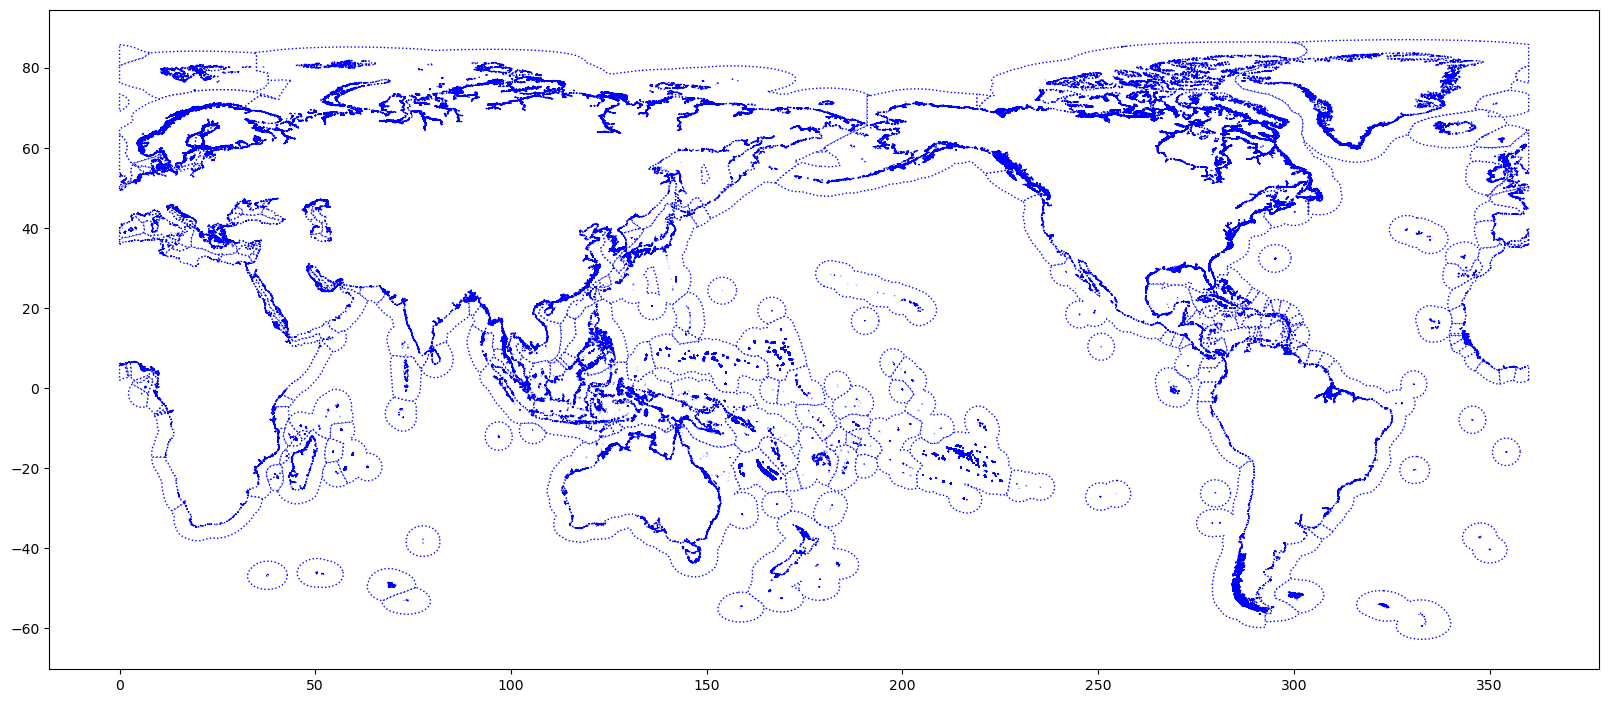

In [6]:
#Plot data to see what it looks like initially
eez_data.plot(figsize=(20,15), color='white', edgecolor='blue',linestyle=":")


In [7]:
#Cut down EEZ data to only include EEZs within the Arctic Circle.
arctic_eez = eez_data.cx[:,60:]

In [8]:
#Dissolve EEZ boundaries by sovereign country so we end up with one EEZ polygon for each Arctic State
cntry_eez = arctic_eez.dissolve(by='SOVEREIGN1', aggfunc='sum', as_index=False, sort=False)

In [9]:
cntry_eez.head()

,SOVEREIGN1,geometry
0,Denmark,"MULTIPOLYGON (((0 85.761, 0.0010649 85.761, 0...."
1,Iceland,"POLYGON ((347.84 69.578, 347.86 69.58, 347.86 ..."
2,United Kingdom,"MULTIPOLYGON (((360 53.541, 360 53.541, 360 53..."
3,Canada,"MULTIPOLYGON (((227.14 68.965, 227.15 68.965, ..."
4,Finland,"POLYGON ((27.36 60.488, 27.364 60.49, 27.371 6..."


In [10]:
#Check the CRS for the EEZ data
cntry_eez.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [11]:
#Reproject data onto North Pole Azimuthal Equidistant CRS for accurate plotting: https://gis.stackexchange.com/questions/387091/how-to-plot-coordinate-system-from-epsg-4326-on-north-pole-centered-map-in-pytho
cntry_eez_new = cntry_eez.to_crs('+proj=aeqd +lat_0=90')

In [12]:
cntry_eez_new.crs

<Projected CRS: +proj=aeqd +lat_0=90 +type=crs>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Modified Azimuthal Equidistant
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<GeoAxes: >

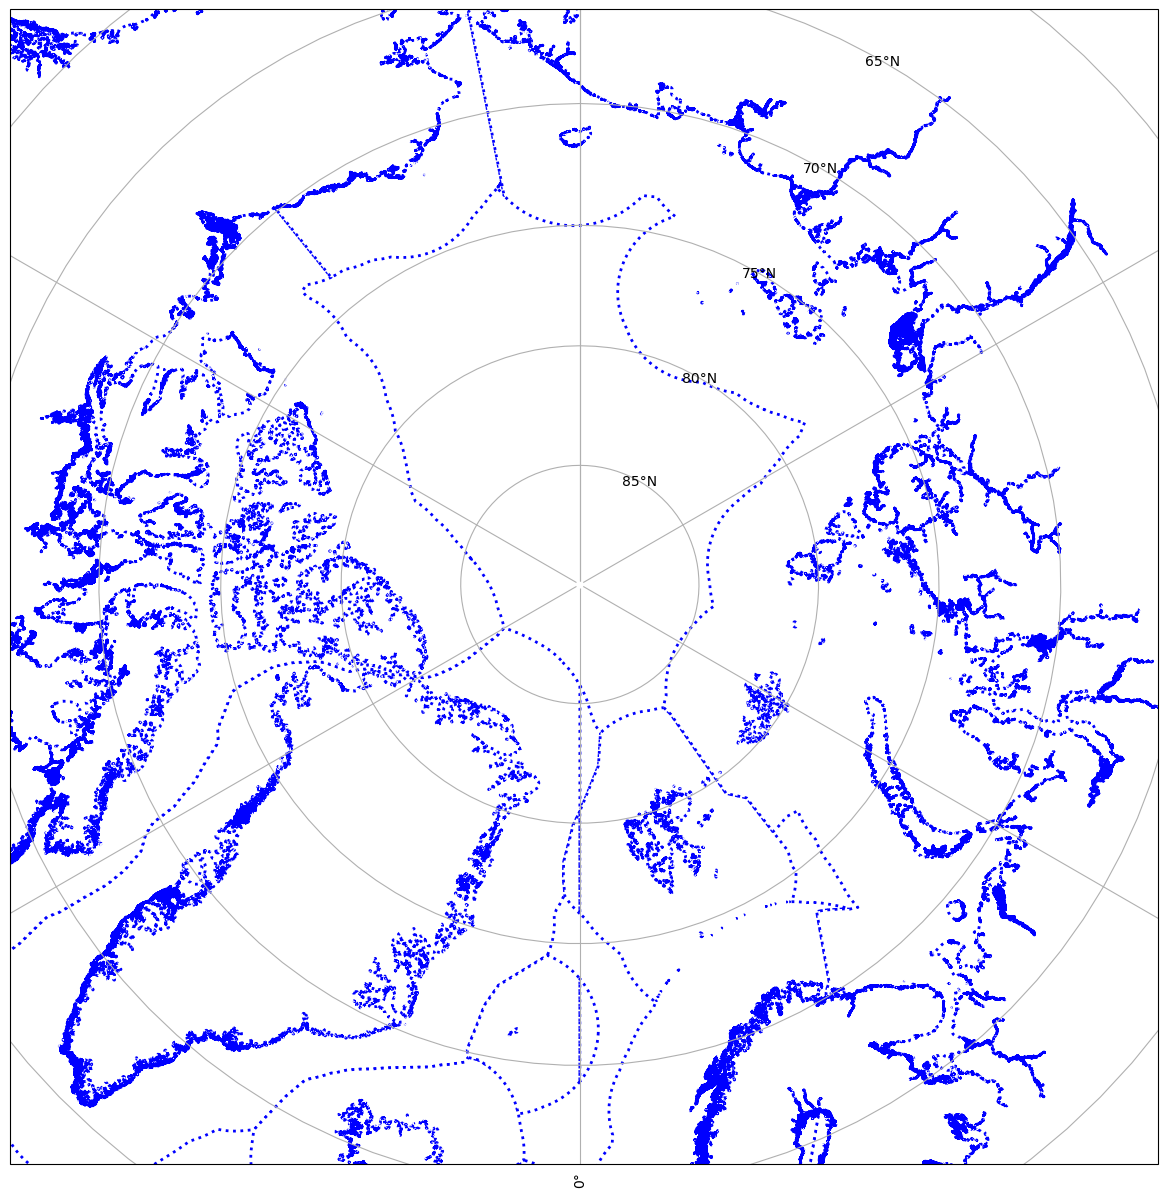

In [28]:
#Define map projection
proj=ccrs.NorthPolarStereo(central_longitude=0)

#Create a figure with an axes object on which we will plot. Pass the projection to that axes.
fig, ax = plt.subplots(figsize=(15,15),subplot_kw=dict(projection=proj))

#Zoom in on Arctic Circle
ax.set_extent([0, 359, 66, 90], ccrs.PlateCarree())

#Add gridlines
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

#Plot Arctic EEZ data on North Polar Stereo projection
cntry_eez_new.plot(ax=ax, color='white', edgecolor='blue',linestyle=":", lw=2)

In [15]:
#Define Arctic Ocean Area
arctic_area = 14056000000000.0 #m2 to match crs units

In [19]:
#Perform column calculations to get to ice free percentage values for each EEZ
cntry_eez_new['total area'] = cntry_eez_new.geometry.area
cntry_eez_new['arctic ocean percentage'] = cntry_eez_new['total area']/arctic_area

In [20]:
cntry_eez_new

,SOVEREIGN1,geometry,total area,arctic area percentage,arctic ocean percentage
0,Denmark,"MULTIPOLYGON (((0 -4.73e+05, 8.8 -4.74e+05, 11...",2.599752e+12,0.184957,0.184957
1,Iceland,"POLYGON ((-4.8e+05 -2.23e+06, -4.8e+05 -2.23e+...",8.228483e+11,0.058541,0.058541
2,United Kingdom,"MULTIPOLYGON (((0 -4.07e+06, -8.92e-05 -4.07e+...",7.724346e+11,0.054954,0.054954
3,Canada,"MULTIPOLYGON (((-1.72e+06 1.6e+06, -1.72e+06 1...",6.053507e+12,0.430671,0.430671
4,Finland,"POLYGON ((1.51e+06 -2.93e+06, 1.51e+06 -2.92e+...",8.502396e+10,0.006049,0.006049
5,Sweden,"MULTIPOLYGON (((9.82e+05 -2.36e+06, 9.83e+05 -...",1.631665e+11,0.011608,0.011608
6,United States,"POLYGON ((9.12e+05 4.23e+06, 9.29e+05 4.23e+06...",3.907873e+12,0.278022,0.278022
7,Norway,"MULTIPOLYGON (((1.97e+05 -3.76e+06, 1.89e+05 -...",2.062109e+12,0.146707,0.146707
8,Russia,"MULTIPOLYGON (((1.41e+06 -3.61e+06, 1.41e+06 -...",8.037188e+12,0.571798,0.571798


<GeoAxes: title={'center': 'Percent Area of the Arctic Ocean contained within Arctic State EEZs'}>

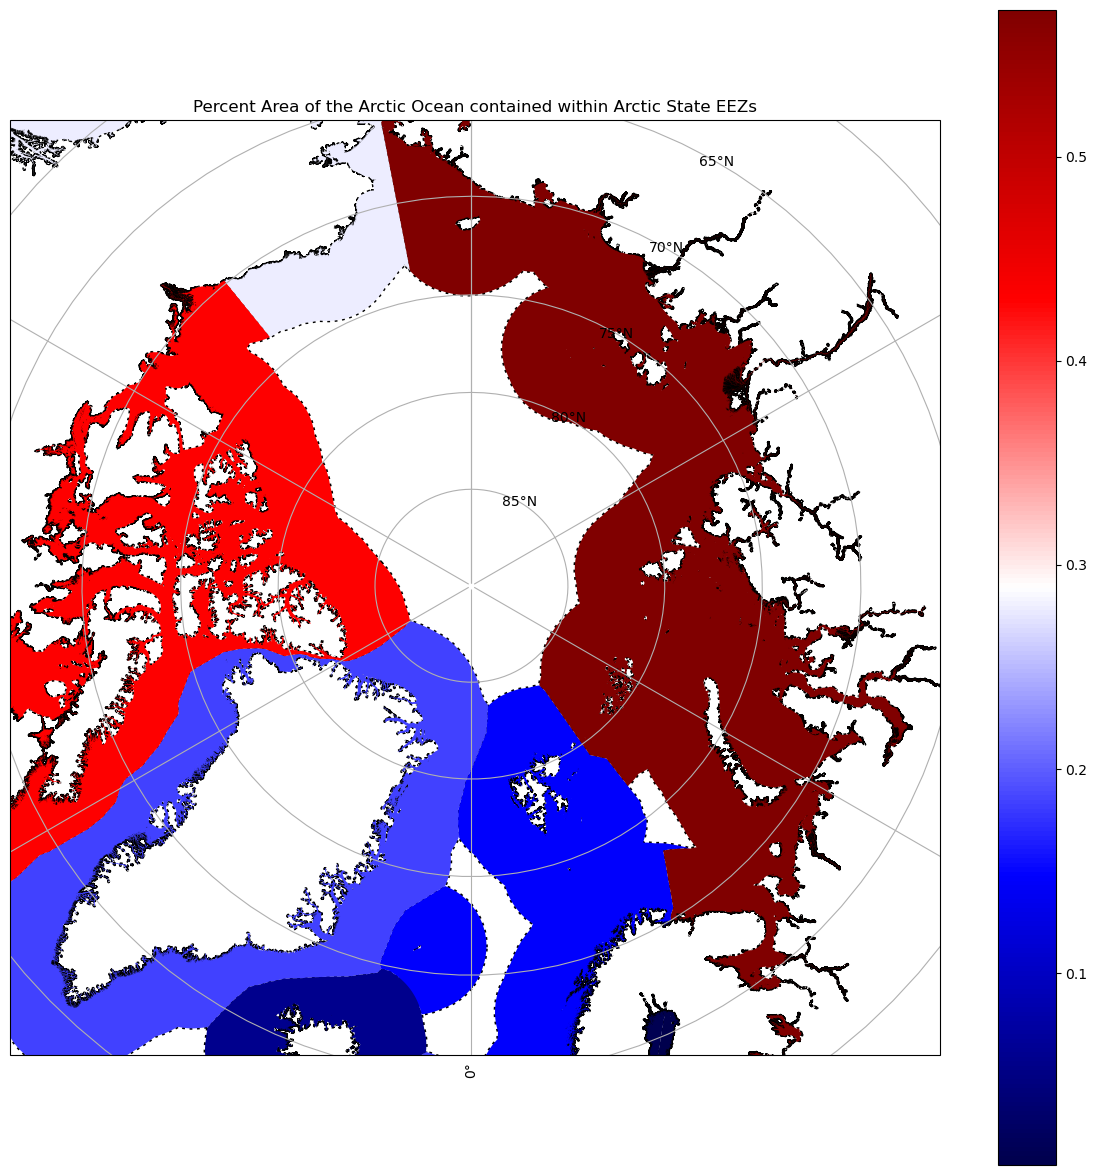

In [23]:
#Create choropleth map based on ice free area percentage of each Arctic State EEZ

#Define map projection
proj=ccrs.NorthPolarStereo(central_longitude=0)

#Create a figure with an axes object on which we will plot. Pass the projection to that axes.
fig, ax = plt.subplots(figsize=(15,15),subplot_kw=dict(projection=proj))

#Zoom in on Arctic Circle
ax.set_extent([0, 359, 66, 90], ccrs.PlateCarree())

#Add gridlines
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

#Add title
ax.set_title('Percent Area of the Arctic Ocean contained within Arctic State EEZs')

cntry_eez_new.plot(ax=ax, color='white', edgecolor='black',linestyle=":", lw=2)
cntry_eez_new.plot(ax=ax, column='arctic ocean percentage', cmap='seismic',legend=True)